In [242]:
from tqdm import tqdm
import pandas as pd
tqdm.pandas(bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.sparse import hstack

## Data Preprocessing, Feature Engineering

### Read movies_weighted.csv

In [243]:
movies_weighted = pd.read_csv("data/movies_weighted.csv")
movies_weighted.rename(columns={"cast_and_crew": "actors"}, inplace=True)

display(movies_weighted.info())
display(movies_weighted.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174935 entries, 0 to 174934
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          174935 non-null  object 
 1   primaryTitle    174935 non-null  object 
 2   startYear       174935 non-null  int64  
 3   runtimeMinutes  174935 non-null  int64  
 4   genres          174935 non-null  object 
 5   averageRating   174935 non-null  float64
 6   numVotes        174935 non-null  int64  
 7   actors          174935 non-null  object 
 8   weightedScore   174935 non-null  float64
 9   highRated       174935 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 13.3+ MB


None

Index(['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'actors', 'weightedScore', 'highRated'],
      dtype='object')

### Add directors and writers using title.crew.tsv

In [244]:
# Load title.crew.tsv
crew_data = pd.read_csv('data/IMDB/title.crew.tsv', sep='\t')

# Merge directors and writers into the movies dataset
movies_final = movies_weighted.merge(crew_data[['tconst', 'directors', 'writers']], on='tconst', how='left')

# Convert actors column from string to list (if needed)
movies_final['actors'] = movies_final['actors'].apply(ast.literal_eval)


### Compute Prior Average Weighted Scores | Compute Prior Total Number of highRated titles associated (actor, director, writer)

In [237]:
movies_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174935 entries, 0 to 174934
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          174935 non-null  object 
 1   primaryTitle    174935 non-null  object 
 2   startYear       174935 non-null  int64  
 3   runtimeMinutes  174935 non-null  int64  
 4   genres          174935 non-null  object 
 5   averageRating   174935 non-null  float64
 6   numVotes        174935 non-null  int64  
 7   actors          174935 non-null  object 
 8   weightedScore   174935 non-null  float64
 9   highRated       174935 non-null  int64  
 10  directors       174935 non-null  object 
 11  writers         174935 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 16.0+ MB


In [238]:
movies_final

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,weightedScore,highRated,directors,writers
0,tt0015724,Dama de noche,1993,102,"Drama,Mystery,Romance",6.3,31,"[Rafael Sánchez Navarro, Cecilia Toussaint, Mi...",5.981423,0,nm0529960,"nm0529960,nm1597742"
1,tt0035423,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,90620,"[Meg Ryan, Hugh Jackman, Liev Schreiber, Breck...",6.309408,0,nm0003506,"nm0737216,nm0003506"
2,tt0036606,"Another Time, Another Place",1983,118,"Drama,War",6.4,364,"[Phyllis Logan, Giovanni Mauriello, Gianluca F...",5.987041,0,nm0705535,"nm0450407,nm0485392,nm0705535"
3,tt0038687,Let There Be Light,1980,58,"Documentary,War",7.4,2063,[Walter Huston],6.089196,0,nm0001379,"nm0001379,nm0442105"
4,tt0057461,La rosa de los vientos,1983,84,"Drama,Fantasy",4.2,27,"[Patxi Andión, José Antonio Rodríguez, Nelson ...",5.979107,0,nm0350099,"nm1104994,nm0350099,nm0489739"
...,...,...,...,...,...,...,...,...,...,...,...,...
174930,tt9916190,Safeguard,2020,95,"Action,Adventure,Thriller",3.6,262,"[Patrick Gallagher, Takayuki Suzuki, Lee Byfor...",5.956334,0,nm7308376,nm7308376
174931,tt9916270,Il talento del calabrone,2020,84,Thriller,5.8,1492,"[Sergio Castellitto, Lorenzo Richelmy, Anna Fo...",5.970833,0,nm1480867,"nm1480867,nm10538402,nm5584269"
174932,tt9916362,Coven,2020,92,"Drama,History",6.4,5941,"[Amaia Aberasturi, Alex Brendemühl, Daniel Fan...",6.061475,0,nm1893148,"nm1893148,nm3471432"
174933,tt9916538,Kuambil Lagi Hatiku,2019,123,Drama,8.3,9,"[Lala Karmela, Cut Mini Theo, Sahil Shah, Ria ...",5.981863,0,nm4457074,"nm4843252,nm4900525,nm2679404"


In [239]:
# Explode actors, directors, and writers columns
movies_exploded_actors = movies_final.explode('actors')
movies_exploded_directors = movies_final.explode('directors')
movies_exploded_writers = movies_final.explode('writers')

# Sort the datasets
movies_exploded_actors = movies_exploded_actors.sort_values(by=['startYear', 'tconst'])
movies_exploded_directors = movies_exploded_directors.sort_values(by=['startYear', 'tconst'])
movies_exploded_writers = movies_exploded_writers.sort_values(by=['startYear', 'tconst'])

# Drop duplicate rows based on tconst and actors
movies_exploded_actors = movies_exploded_actors.drop_duplicates(subset=['tconst', 'actors']).reset_index(drop=True)
movies_exploded_directors = movies_exploded_directors.drop_duplicates(subset=['tconst', 'directors']).reset_index(drop=True)
movies_exploded_writers = movies_exploded_writers.drop_duplicates(subset=['tconst', 'writers']).reset_index(drop=True)

# Compute prior weightedScore and total highRated titles for actors
movies_exploded_actors['prior_weightedScore_actor'] = (
    movies_exploded_actors
    .groupby('actors')['weightedScore']
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

movies_exploded_actors['prior_highRated_actor'] = (
    movies_exploded_actors
    .groupby('actors')['highRated']
    .cumsum()
    .shift()
)

# Compute prior weightedScore and total highRated titles for directors
movies_exploded_directors['prior_weightedScore_director'] = (
    movies_exploded_directors
    .groupby('directors')['weightedScore']
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

movies_exploded_directors['prior_highRated_director'] = (
    movies_exploded_directors
    .groupby('directors')['highRated']
    .cumsum()
    .shift()
)

# Compute prior weightedScore and total highRated titles for writers
movies_exploded_writers['prior_weightedScore_writer'] = (
    movies_exploded_writers
    .groupby('writers')['weightedScore']
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

movies_exploded_writers['prior_highRated_writer'] = (
    movies_exploded_writers
    .groupby('writers')['highRated']
    .cumsum()
    .shift()
)

# Aggregate back to the movie level
actor_stats = movies_exploded_actors.groupby('tconst').agg({
    'prior_weightedScore_actor': 'mean',
    'prior_highRated_actor': 'sum'
})

director_stats = movies_exploded_directors.groupby('tconst').agg({
    'prior_weightedScore_director': 'mean',
    'prior_highRated_director': 'sum'
})

writer_stats = movies_exploded_writers.groupby('tconst').agg({
    'prior_weightedScore_writer': 'mean',
    'prior_highRated_writer': 'sum'
})

# Fill NaN values with 0 (for contributors with no prior movies)
movies_final.fillna(0, inplace=True)

# Merge prior stats back to the main dataset
movies_final = movies_final.merge(actor_stats, on='tconst', how='left')
movies_final = movies_final.merge(director_stats, on='tconst', how='left')
movies_final = movies_final.merge(writer_stats, on='tconst', how='left')
movies_final

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,weightedScore,highRated,directors,writers,prior_weightedScore_actor,prior_highRated_actor,prior_weightedScore_director,prior_highRated_director,prior_weightedScore_writer,prior_highRated_writer
0,tt0015724,Dama de noche,1993,102,"Drama,Mystery,Romance",6.3,31,"[Rafael Sánchez Navarro, Cecilia Toussaint, Mi...",5.981423,0,nm0529960,"nm0529960,nm1597742",5.995058,0.0,5.982516,0.0,5.983214,0.0
1,tt0035423,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,90620,"[Meg Ryan, Hugh Jackman, Liev Schreiber, Breck...",6.309408,0,nm0003506,"nm0737216,nm0003506",6.181519,6.0,6.698645,0.0,6.413224,1.0
2,tt0036606,"Another Time, Another Place",1983,118,"Drama,War",6.4,364,"[Phyllis Logan, Giovanni Mauriello, Gianluca F...",5.987041,0,nm0705535,"nm0450407,nm0485392,nm0705535",5.978538,0.0,5.982067,0.0,5.878762,0.0
3,tt0038687,Let There Be Light,1980,58,"Documentary,War",7.4,2063,[Walter Huston],6.089196,0,nm0001379,"nm0001379,nm0442105",5.980920,0.0,6.110557,0.0,6.472888,0.0
4,tt0057461,La rosa de los vientos,1983,84,"Drama,Fantasy",4.2,27,"[Patxi Andión, José Antonio Rodríguez, Nelson ...",5.979107,0,nm0350099,"nm1104994,nm0350099,nm0489739",5.980603,0.0,5.979563,0.0,5.981639,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174930,tt9916190,Safeguard,2020,95,"Action,Adventure,Thriller",3.6,262,"[Patrick Gallagher, Takayuki Suzuki, Lee Byfor...",5.956334,0,nm7308376,nm7308376,5.972472,0.0,5.981796,0.0,5.973163,0.0
174931,tt9916270,Il talento del calabrone,2020,84,Thriller,5.8,1492,"[Sergio Castellitto, Lorenzo Richelmy, Anna Fo...",5.970833,0,nm1480867,"nm1480867,nm10538402,nm5584269",5.994095,2.0,5.943727,0.0,5.299407,0.0
174932,tt9916362,Coven,2020,92,"Drama,History",6.4,5941,"[Amaia Aberasturi, Alex Brendemühl, Daniel Fan...",6.061475,0,nm1893148,"nm1893148,nm3471432",5.998706,0.0,5.978293,0.0,5.978293,0.0
174933,tt9916538,Kuambil Lagi Hatiku,2019,123,Drama,8.3,9,"[Lala Karmela, Cut Mini Theo, Sahil Shah, Ria ...",5.981863,0,nm4457074,"nm4843252,nm4900525,nm2679404",5.970830,0.0,5.985087,0.0,5.954722,0.0


### One-hot encode Genres

In [240]:
# Split genres and perform one-hot encoding
genres_expanded = movies_final['genres'].str.get_dummies(sep=',')
# genres_expanded = movies_final['genres'].str.get_dummies()
movies_final = pd.concat([movies_final, genres_expanded], axis=1)
# display(movies_final.head())
display(movies_final.columns)

Index(['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'actors', 'weightedScore', 'highRated',
       'directors', 'writers', 'prior_weightedScore_actor',
       'prior_highRated_actor', 'prior_weightedScore_director',
       'prior_highRated_director', 'prior_weightedScore_writer',
       'prior_highRated_writer', 'Action', 'Adult', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

In [248]:
movies_final.drop("weightedScore", axis=1).to_csv("movies.csv", index=False)

### Drop Unnecessary Variables

In [199]:
to_drop = [
    'startYear','tconst', 'primaryTitle', 'genres',
    'averageRating', 'numVotes', 'actors', 'weightedScore', 
    'directors', 'writers'
          ]
movies_final = movies_final.drop(to_drop, axis=1) #axis =1 to drop columns

In [200]:
display(movies_final.columns)

Index(['runtimeMinutes', 'highRated', 'prior_weightedScore_actor',
       'prior_highRated_actor', 'prior_weightedScore_director',
       'prior_highRated_director', 'prior_weightedScore_writer',
       'prior_highRated_writer', 'Action', 'Adult', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

### Correlation

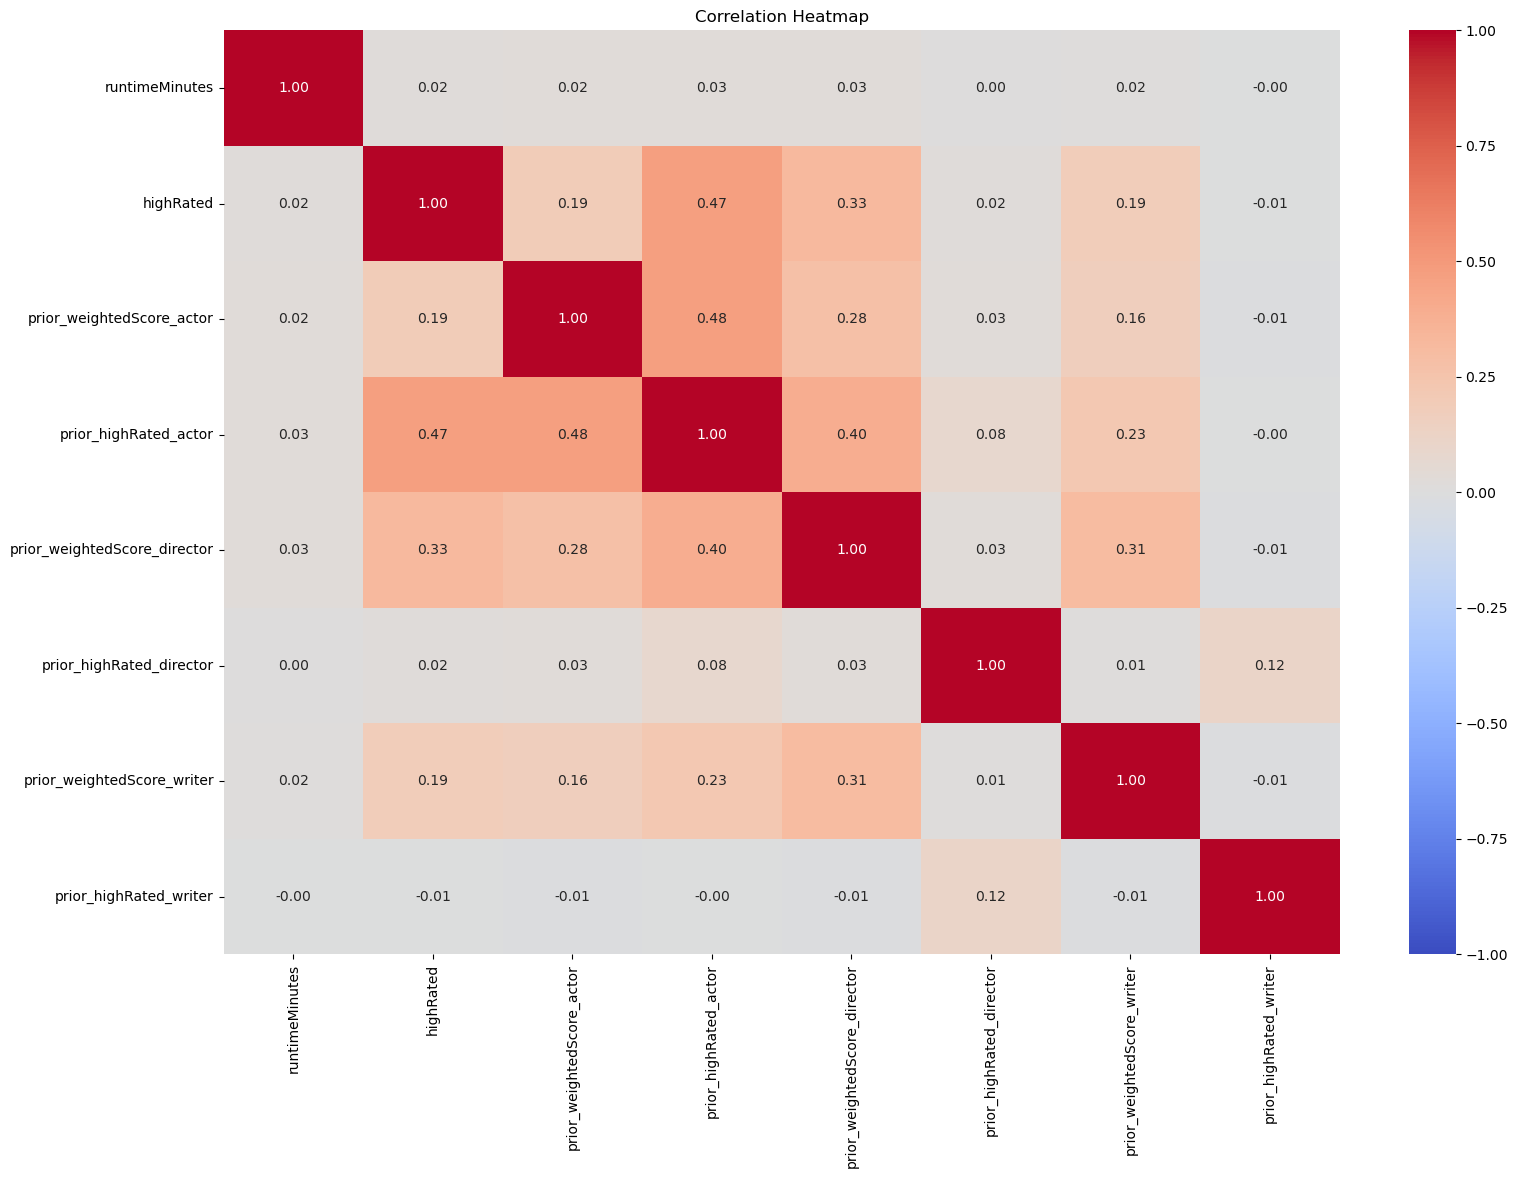

In [202]:
# Select numerical columns for correlation analysis
correlation_columns = [
    'runtimeMinutes', 'highRated', 'prior_weightedScore_actor',
       'prior_highRated_actor', 
    'prior_weightedScore_director',
       'prior_highRated_director', 
    'prior_weightedScore_writer',
       'prior_highRated_writer',
]

# Filter the dataset
correlation_data = movies_final[correlation_columns]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


This matrix helps me understand how my predictors relate to each other and to the target variable (highRated). It ensures I focus on variables that truly impact the model's performance while avoiding redundancy.

**Key Findings:**
- Variables like **prior_highRated_actor** and **prior_weightedScore_actor** show **moderate to strong correlations** (0.47–0.48) with **highRated**. This confirms that actors' past success is a key driver of high movie ratings.
- **Directors' and writers' prior weighted scores** also show **moderate correlations** (~0.31 and 0.19, respectively), suggesting they are relevant but less impactful.
- Variables like **prior_highRated_director** and **prior_highRated_writer** have **very weak correlations** with highRated (~0.02–0.14). These might contribute less to the model.
- **startYear** and **runtimeMinutes** have **near-zero correlations**, showing they likely don't influence a movie's rating directly.


In [203]:
movies_final.to_csv("data/movies_final.csv", index=False)

In [204]:
movies_final

,runtimeMinutes,highRated,prior_weightedScore_actor,prior_highRated_actor,prior_weightedScore_director,prior_highRated_director,prior_weightedScore_writer,prior_highRated_writer,Action,Adult,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,102,0,5.995058,0.0,5.982516,0.0,5.983214,0.0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,118,0,6.181519,6.0,6.698645,0.0,6.413224,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,118,0,5.978538,0.0,5.982067,0.0,5.878762,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,58,0,5.980920,0.0,6.110557,0.0,6.472888,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,84,0,5.980603,0.0,5.979563,0.0,5.981639,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174930,95,0,5.972472,0.0,5.981796,0.0,5.973163,0.0,1,0,...,0,0,0,0,0,0,0,1,0,0
174931,84,0,5.994095,2.0,5.943727,0.0,5.299407,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
174932,92,0,5.998706,0.0,5.978293,0.0,5.978293,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
174933,123,0,5.970830,0.0,5.985087,0.0,5.954722,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## ML Pipeline

### Train Validation Holdout Split

In [206]:
# modelling
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)

In [207]:
df = movies_final.copy()
df.fillna(0, inplace=True)
df_null = pd.isnull(df).sum()
columns_with_null = df_null[df_null > 0]
columns_with_null

Series([], dtype: int64)

In [208]:
X = df.drop(['highRated'], axis=1)
y = df['highRated']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

In [209]:
display(y_trainval.value_counts())
display(y_holdout.value_counts())

highRated
0    130152
1      1049
Name: count, dtype: int64

highRated
0    43384
1      350
Name: count, dtype: int64

### Auto-ML

In [2]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):

        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        train_precision = []
        val_precision = []

        train_f1 = []
        val_f1 = []


        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)

            #########################################################

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            # precision
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))

            # F1 score
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))
            
            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train f1': np.round(np.mean(train_f1) * 100, 2),
                'Val f1`': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train f1': np.round(np.mean(train_f1) * 100, 2),
                'Val f1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline Models

In [231]:
# general libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# modelling
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, precision_score, f1_score)

# imbalanced techniques
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN

# interpretability
import shap

# model deployment
#from flask import Flask
import streamlit as st


In [226]:
models_dict = {
               'RandomForestClassifier': RandomForestClassifier(random_state=143),
               'XGBoost': XGBClassifier(random_state=143),
}

In [227]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict,
                   scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train f1,Val f1,Run Time
RandomForestClassifier,100.00%,99.33%,100.00%,29.74%,100.0,69.3,100.0,41.58,8.736971
XGBoost,99.90%,99.32%,88.49%,42.42%,98.75,60.33,93.34,49.8,1.095757


**Analysis:**

-------------------------
Between the two base models:

1. **XGBoost performs better overall**, with higher validation recall (42.42%) and F1-score (49.8%), while also being faster (~1.1 seconds vs. ~8.7 seconds for Random Forest). It's less overfitted and generalizes better.
2. **RandomForestClassifier is heavily overfitted** (100% train recall) and struggles to generalize, with poor validation recall (29.74%) despite perfect precision (100%), indicating it's overly conservative.

***For better results, XGBoost is the better choice, but both models would benefit from resampling and hyperparameter tuning.***

### OVERSAMPLING USING SMOTE / ADASYN

In [232]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict,
                  scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.12614035606384277
Resampling done in 0.13515400886535645
Resampling done in 0.10922074317932129
Resampling done in 0.14763617515563965
Resampling done in 0.1191709041595459


0it [00:00, ?it/s]

Resampling done in 0.14165115356445312
Resampling done in 0.12072873115539551
Resampling done in 0.12968158721923828
Resampling done in 0.1261765956878662
Resampling done in 0.14211082458496094


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train f1,Val f1,Run Time
RandomForestClassifier,100.00%,98.75%,100.00%,77.31%,100.0,36.92,100.0,49.91,44.939273
XGBoost,99.70%,98.83%,99.97%,73.98%,99.44,38.32,99.7,50.44,2.553741


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.39302611351013184
Resampling done in 0.2528684139251709
Resampling done in 0.2159721851348877
Resampling done in 0.2877681255340576
Resampling done in 0.23703932762145996


0it [00:00, ?it/s]

Resampling done in 0.2214980125427246
Resampling done in 0.24537873268127441
Resampling done in 0.25134897232055664
Resampling done in 0.3286404609680176
Resampling done in 0.2633676528930664


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train f1,Val f1,Run Time
RandomForestClassifier,100.00%,98.73%,100.00%,76.45%,100.0,36.32,100.0,49.2,36.2246
XGBoost,99.69%,98.80%,99.97%,74.17%,99.42,37.42,99.69,49.72,2.668935


**Analysis:**

-------------------------
Summary:
1. Both resampling techniques dramatically improve recall compared to the base models.
2. For Random Forest, SMOTE slightly outperforms ADASYN in recall, while XGBoost shows nearly identical recall for both methods.
3. SMOTE is better for maximizing recall. ADASYN is a valid alternative.

### RandomForestClassifier (SMOTE Resampling + Hypertuning)

In [39]:
def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {
        "n_estimators": [10, 50, 100],
        "max_depth": [None, 10, 20],
    }
    new_params = {'randomforestclassifier__' + key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(
            MinMaxScaler(),
            res_t,
            RandomForestClassifier(random_state=143)
        )
    else:
        imba_pipeline = make_pipeline(
            MinMaxScaler(),
            RandomForestClassifier(random_state=143)
        )

    if hypertune is True:
        clf = GridSearchCV(
            imba_pipeline, param_grid=new_params, 
            cv=skf, scoring=metric, return_train_score=True,
            verbose=10
        )
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Random Forest Classifier', 
                np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 
                'Best parameters = {0}'.format(clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(
            estimator=clf, X=X, y=y, 
            scoring=metric, cv=skf, n_jobs=-1, 
            return_train_score=True
        )
        return ['Random Forest Classifier', 
                np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), 
                run_time, clf]

In [220]:
start_time = time.time()
rf_rec = train_rf(X_trainval, y_trainval, 'recall', SMOTE(),
                       hypertune=True, resample=True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10
[CV 1/5; 1/9] END randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10;, score=(train=0.999, test=0.733) total time=   3.2s
[CV 2/5; 1/9] START randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10
[CV 2/5; 1/9] END randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10;, score=(train=1.000, test=0.689) total time=   3.3s
[CV 3/5; 1/9] START randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10
[CV 3/5; 1/9] END randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10;, score=(train=0.999, test=0.676) total time=   3.3s
[CV 4/5; 1/9] START randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=10
[CV 4/5; 1/9] END randomforestclassifier__max_depth=None, randomforestclassifier__n_est

In [221]:
rf_rec

['Random Forest Classifier',
 0.9966900315946801,
 0.969501025290499,
 "Best parameters = {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}",
 888.9064211845398,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('smote', SMOTE()),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=10, random_state=143))])]

In [222]:
# re-fitting for the holdout
rh = rf_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds_ = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds_)

In [223]:
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [224]:
# cross-validation (resampling)
res_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=True, res_t=SMOTE())

# re-fitting for the holdout
res_model = res_var[-1]
res_model.fit(X_trainval, y_trainval)
y_preds = res_model.predict(X_holdout)
res_holdout_score = recall_score(y_holdout, y_preds)

In [225]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]

summary.loc[1] = ['Resampling',
                 '{:.2f}%'.format(np.round(res_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(res_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(res_holdout_score*100, 2))]

summary.loc[2] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style

,Method,Train Recall,Val Recall,Holdout Recall
0,No Resampling,100.00%,29.74%,31.71%
1,Resampling,100.00%,76.55%,77.71%
2,Resampling x Hypertune,99.67%,96.95%,97.14%


#### Results Summary

The table above shows how different techniques improve the recall of a **Random Forest model** when predicting AAA movie titles.

1. **No Resampling**: Without resampling, the model overfits—achieving perfect recall (100%) on the training set but very low recall on validation (29.74%) and holdout (31.71%).
2. **Resampling with SMOTE**: Using SMOTE to balance the dataset **significantly improves recall**, boosting validation recall to 76.55% and holdout recall to 77.71%. This shows the **model generalizes much better**.
3. **Resampling + Hyperparameter Tuning**: By **tuning n_estimators** (10, 50, 100) **and max_depth** (None, 10, 20) after applying SMOTE, the model achieves the best results. Validation recall reaches **96.95%**, and holdout recall improves to **97.14%**, showing a well-optimized and balanced model.

***Please see notebook [3] to continue...*** 